In [1]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path
import random
import numpy as np

from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle

In [2]:
with open(f"upstream_model_18_0_2500.pkl","rb")as f:
    upstream_model = pickle.load(f)

In [3]:
with open(f"error_params_predicts_execute_18bits_train_0_2500_bias.pkl","rb")as f:
# with open(f"error_params_predicts_execute_18bits_train_0_2500.pkl","rb")as f:
    downstream_model, predicts, reals, durations = pickle.load(f)
error_params = downstream_model.error_params
print(error_params)
error_params = downstream_model.error_params['gate_params']

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


{'circuit_bias': Array([-74.10199], dtype=float32), 'gate_params': Array([[5.5104822e-02, 7.0192432e-03, 1.3777038e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [6.6061602e+00, 7.6305266e-03, 1.0322740e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [5.1740998e-01, 7.6044691e-03, 2.4176327e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.5225390e+01, 4.2706898e+01, 2.4880020e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.3495053e-01, 1.7051668e+01, 2.6067852e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.9522758e+01, 3.1537554e+01, 5.0256915e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)}


In [4]:
# with open(f"error_params_predicts_execute_18bits_train_0_2500_bias.pkl","rb")as f:
# with open(f"error_params_predicts_execute_18bits_train_0_2500.pkl","rb")as f:
#     error_params, predicts, reals, durations = pickle.load(f)
# error_params = downstream_model.error_params

In [5]:
downstream_model.error_params

{'circuit_bias': Array([-74.10199], dtype=float32),
 'gate_params': Array([[5.5104822e-02, 7.0192432e-03, 1.3777038e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [6.6061602e+00, 7.6305266e-03, 1.0322740e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [5.1740998e-01, 7.6044691e-03, 2.4176327e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [1.5225390e+01, 4.2706898e+01, 2.4880020e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [9.3495053e-01, 1.7051668e+01, 2.6067852e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [3.9522758e+01, 3.1537554e+01, 5.0256915e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)}

In [6]:
# list(downstream_model.error_params['gate_params'])

In [7]:
# error_params = error_params['gate_params']

In [8]:
with open(f"split_dataset_execute_18bits_train_0_2500.pkl","rb")as f:
    train_dataset, test_dataset = pickle.load(f)

In [9]:
reals = []
for idx, cir in enumerate(test_dataset):
    reals.append(cir['ground_truth_fidelity'])

In [10]:
len(reals)

1500

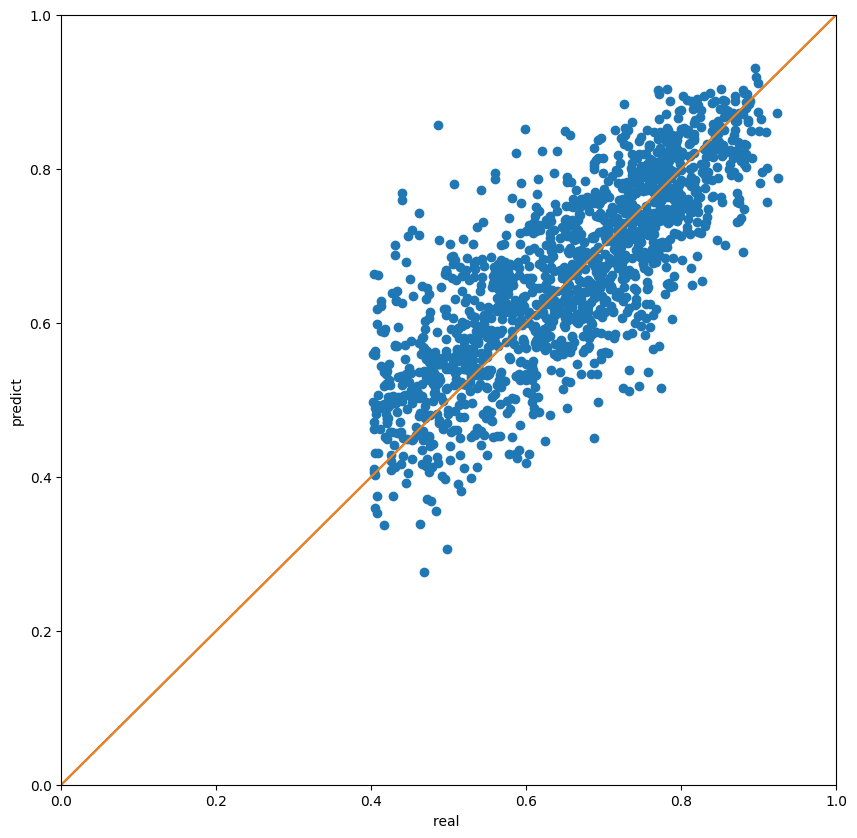

In [11]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, predicts)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('18qubit_predict_step1.png')

In [12]:
device_index2device = {}  # 两比特门与但单比特门映射为一维下标
for device in upstream_model.device2path_table.keys():
    device_index = list(
        upstream_model.device2path_table.keys()).index(device)
    device_index2device[device_index] = device

error_params_path_weight = {}  # 训练好的参数对应的path及其权重
error_params_path = {}
for idx, device_error_param in enumerate(error_params):
    device = device_index2device[idx]
    sort = np.argsort(device_error_param)
    sort = sort[::-1]
    device_error_params_path_weight = []
    device_error_params_path = []
    for i in sort:
        if int(i) in upstream_model.device2reverse_path_table[device].keys():
            path = upstream_model.device2reverse_path_table[device][int(i)]
            if isinstance(path, str):
                device_error_params_path_weight.append(
                    (path, float(device_error_param[i])))
                device_error_params_path.append(path)
    error_params_path_weight[device] = device_error_params_path_weight
    error_params_path[device] = device_error_params_path
    
error_params_path_weight

/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3485: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


{0: [('ry,0-parallel-cz,6,12', 57.87481689453125),
  ('rz,0-parallel-cz,6,12', 57.23011016845703),
  ('rx,0-former-cz,6,12', 54.446598052978516),
  ('rz,0-former-cz,6,12', 49.626434326171875),
  ('ry,0-former-cz,6,12', 33.99186706542969),
  ('ry,0-former-cz,0,6', 31.99451446533203),
  ('ry,0-former-cz,0,1', 30.438182830810547),
  ('rx,0-former-cz,0,6', 28.98582649230957),
  ('rx,0-parallel-cz,1,2', 25.642318725585938),
  ('rz,0-former-cz,0,1', 24.372465133666992),
  ('rz,0-parallel-cz,1,2', 24.106420516967773),
  ('rx,0-parallel-cz,6,7', 20.705629348754883),
  ('ry,0-former-cz,6,7', 19.767547607421875),
  ('ry,0', 19.005661010742188),
  ('rx,0-parallel-cz,6,12', 18.68248176574707),
  ('ry,0-former-cz,1,2', 16.94984245300293),
  ('rx,0-former-rx,0', 16.09337615966797),
  ('rz,0-former-rz,0', 15.705180168151855),
  ('rz,0-former-ry,0', 14.830892562866211),
  ('ry,0-former-rz,0', 14.830642700195312),
  ('rz,0', 11.346132278442383),
  ('ry,0-parallel-ry,6', 8.546550750732422),
  ('ry,0-for

In [ ]:
all_path_error =[]
for device in error_params_path_weight.items():
    error_params_path_weight

In [13]:
from openpyxl import Workbook
wb = Workbook()

for device, device_error_params_path_weight in error_params_path_weight.items():
    ws = wb.create_sheet(str(device))
    for row in device_error_params_path_weight:
        row = list(row)
        ws.append(row)

# Save the file
wb.save("execute_18bits_train_0_2500.xlsx")

In [14]:
single_average_error = {0: 0.9994094148043156,
 1: 0.9993508083886652,
 2: 0.9993513578387458,
 3: 0.9996978330672296,
 4: 0.9997258463524775,
 5: 0.9993898065578337,
 6: 0.9998335484697743,
 7: 0.9997460044815009,
 8: 0.9997219426985601,
 9: 0.9992924485427597,
 10: 0.9994018918682177,
 11: 0.9998410411794697,
 12: 0.9994231683912435,
 13: 0.9995938422219371,
 14: 0.9947661045069707,
 15: 0.9997576786354693,
 16: 0.9998387638441334,
 17: 0.9996691783504945}

In [15]:
couple_average_error = {(5,11): 0.993651602350742,
 (11,17): 0.9943374306798481,
 (4,5): 0.9810612795342519,
 (10,11): 0.9915544427978213,
 (16,17): 0.9908639448675425,
 (4,10): 0.9914941121128581,
 (10,16): 0.9868303060599511,
 (3,4): 0.9899226069903224,
 (9,10): 0.9945250360193374,
 (15,16): 0.9933864398113101,
 (3,9): 0.991508018299962,
 (9,15): 0.993773364368622,
 (2,3): 0.9802169505904027,
 (8,9): 0.9912794178832776,
 (14,15): 0.9867247971867894,
 (2,8): 0.9765590682588615,
 (8,14): 0.9863913339619792,
 (1,2): 0.9713229087974011,
 (7,8): 0.9908463216114999,
 (13,14): 0.9564265490465305,
 (1,7): 0.9856880460026779,
 (7,13): 0.9935440562158602,
 (0,1): 0.9833453296232256,
 (6,7): 0.9939901490743566,
 (12,13): 0.9821366244436676,
 (0,6): 0.9861987068804432,
 (6,12): 0.9863008252688662}

In [16]:
from upstream.randomwalk_model import extract_device
def get_xeb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error[device]
        else:
            device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)

In [17]:
xebs = []
for cir in test_dataset:
    xebs.append(get_xeb_fidelity(cir))

In [18]:
xebs

[0.8736286644432479,
 0.9369276243377055,
 0.7960196196342897,
 0.6971592487722876,
 0.8462673304720921,
 0.9653242479133063,
 0.7787212134611046,
 0.9332751584603469,
 0.6391693449285044,
 0.7373976396415755,
 0.7933074137614153,
 0.8968518898478515,
 0.47989271319431176,
 0.7139146490909641,
 0.6174687527255347,
 0.7648745168761527,
 0.7521928286219638,
 0.7374371577736656,
 0.8551372300428636,
 0.8695944712474919,
 0.8360246726756818,
 0.9428719642922346,
 0.8867580695439281,
 0.9518531135755622,
 0.9602128709785219,
 0.7051832145694203,
 0.7989590757521977,
 0.8600855075490128,
 0.5330635506744985,
 0.7307460339703423,
 0.8943998796610606,
 0.6894255483943483,
 0.9464577526918325,
 0.7336190442519553,
 0.8673504211230387,
 0.925828878502469,
 0.7737476167103274,
 0.8546468715071774,
 0.8397129267989656,
 0.6863227868136911,
 0.931740186953743,
 0.9090429795857743,
 0.952871496898965,
 0.859147721942099,
 0.9157471684979994,
 0.9352298867772523,
 0.8881493288056711,
 0.8390282737103

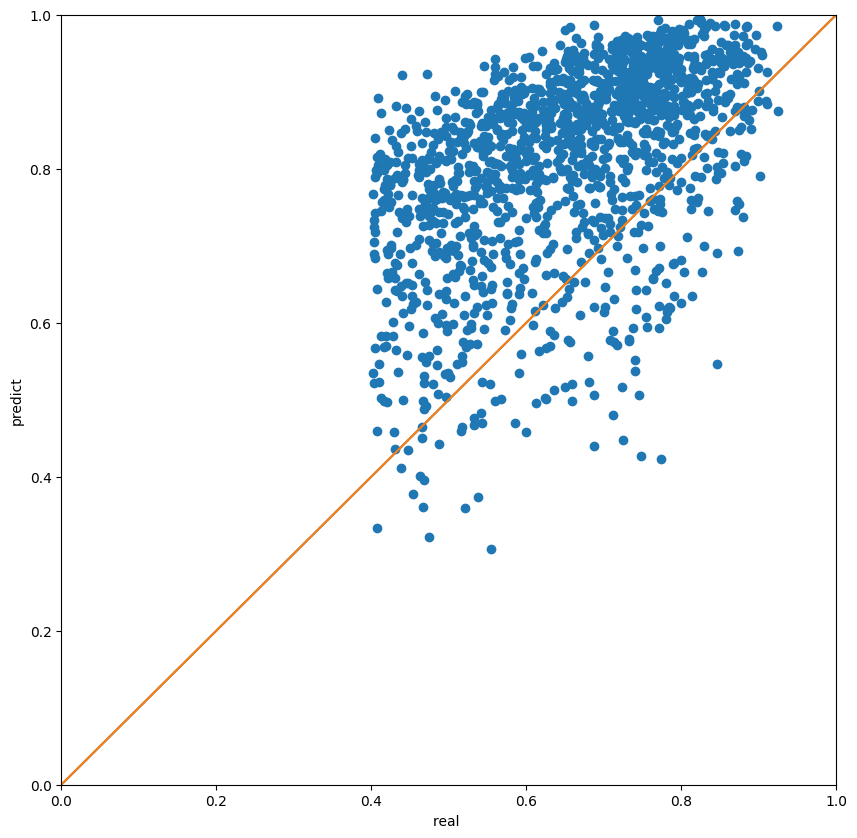

In [19]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, xebs)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('./18_qubit_xeb.png')